# 1. 初始準備

In [2]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

In [4]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

Using TensorFlow backend.


# 2. 讀入 MNIST 數據庫
老規矩，開場就先召喚我們的好朋友 - MNIST 手寫數字數據庫

In [5]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

print("There are %d training data with size %d x %d" %x_train0.shape)
print("There are %d testing  data with size %d x %d" %x_test0.shape)

11493376/11490434 [==============================] - 0s 0us/step
There are 60000 training data with size 28 x 28
There are 10000 testing  data with size 28 x 28


調整資料長相及單位化

In [0]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

# 3.Variational Autoencoder
若每筆資料的 latent 不僅僅是一個**位置**，而是一個分布，且分布的平均值附近都能還原，那我們應該怎麼做呢？

在此，我們將介紹 Variational Autoencder，一種當代知名的自編碼器，就具有上述的效果。

此時 $\mbox{Enc}$ 和 $\mbox{Dec}$ 並不直接串接，而是會透過一常態抽樣的函數以下面的形式串接。

$$ \mathbb{R}^n \overset{\mbox{Enc}}{\to} \mathbb{R}^m\times\mathbb{R}^m \overset{\mbox{Sampling}}{\to} \mathbb{R}^m \overset{\mbox{Dec}}{\to} \mathbb{R}^n$$

$$ x \overset{\mbox{Enc}}{\mapsto} (\mu, \sigma^2) \overset{\mbox{Sampling}}{\mapsto} h \overset{\mbox{Dec}}{\mapsto} \hat{x} $$


我們準備建構的 Variational Autoencoder 的結構如下：

<img src="variational_autoencoder.png" alt="drawing" style="width: 800px;"/>

在此， Encoder 的作用不是將資料表示成 latent，而是將資料表示成常態分配的兩個參數，**平均數與變異數**。

而 Decoder 也不再直接使用 Encoder 的結果，而是將 Encoder 的結果作為常態抽樣的兩個參數來進行。

因此，資料經過 Encoder，會得到一適當大小的常態分配之參數，而 Decoder 則使用這組參數進行抽樣。

即使是同一筆資料，Decoder 每次接受到的 latent 表示法可能都不一樣 (但會在某個平均數附近)。

要注意到的是，由於變異數恆正的特性，我們可以下面是以學習取對數後的變異數 (log-variance)。

## 3.1 VAE 的建立
為了避免混淆，我們重新定義所有變數，首先，我們定義 Encoder 上的三個神經網路層

In [0]:
enc_1 = Dense(100, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2) #var本來就是非負，正數取log就是可正可負

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [8]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

Instructions for updating:
Colocations handled automatically by placer.


定義抽樣函數並透過 ``Lambda`` 將其轉換成 Keras layer。

透過 $X\sim N(0, 1)\Rightarrow \mu+\sigma X\sim N(\mu, \sigma^2)$ 和 $\sigma = e^{\frac{\log{\sigma^2}}{2}}$，我們透過以下方式定義抽樣函數。

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [0]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [0]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [12]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

## 3.2 Loss 函數的建立
VAE 的 loss 函數，其由來牽扯一些訊息理論 (information theory) 的知識，因此，我們在此直接建立訓練 VAE 時的 loss 函數。

若對 VAE 的理論及模型基本設定有興趣的同學，可以參考下列兩篇論文：
* Auto-Encoding Variational Bayes: https://arxiv.org/pdf/1312.6114.pdf
* Tutorial on Variational Autoencoders: https://arxiv.org/pdf/1606.05908.pdf

同學有興趣可以證明下面關於 KL 散度在兩個常態分配上的性質：若 $p\sim N(\mu_1,\sigma_1^2)$, $q\sim N(\mu_2,\sigma_2^2)$，則 $KL(p, q) = \log\dfrac{\sigma_2}{\sigma_1} + \dfrac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\dfrac{1}{2}$

設$(\mu_2,\sigma_2^2) = (0,1)$

$\log\dfrac{1}{\sigma_1}+\dfrac{\sigma_1^2+\mu_1^2}{2}-\dfrac{1}{2}$

$=-\dfrac{1}{2}\log\sigma_1^2+\dfrac{\sigma_1^2+\mu_1^2}{2}-\dfrac{1}{2}$

$=-\dfrac{1}{2}[1+\log\sigma_1^2-\sigma_1^2-\mu_1^2]$

$=-\dfrac{1}{2}[1+\log\sigma_1^2-e^{\log{\sigma_1^2}}-\mu_1^2]$

In [0]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

## 3.3 訓練 VAE

In [0]:
VAE.compile(loss=vae_loss, optimizer=Adam())

In [0]:
# VAE.fit(x_train, x_train, batch_size=32, epochs=100)

colab讀入雲端檔案

In [16]:
!pip install pydrive

     |████████████████████████████████| 993kB 1.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1tKx7pRA5_5mZMEqKjcX02I0-Hvt7nrUq'  #雲端硬碟檔案連結碼
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('VAE_handwriting_model_weights.h5')

Jupyter Notebook讀入文件

In [0]:
VAE.load_weights('VAE_handwriting_model_weights.h5')

## 3.4 VAE 的視覺化呈現
與視覺化 Autoencoder 時的方式一樣，我們先分別定義出 Encoder 和 Decoder。

$$\mbox{VAE:}~x \overset{\mbox{Enc}}{\mapsto} (\mu, \sigma^2) \overset{\mbox{Sampling}}{\mapsto} h \overset{\mbox{Dec}}{\mapsto} \hat{x} $$
$$\mbox{Encoder:}~x \overset{\mbox{Enc}}{\mapsto} \mu$$
$$\mbox{Decoder:}~h \overset{\mbox{Dec}}{\mapsto} \hat{x}$$

In [19]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [20]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


首先，我們進行 Encoder 的視覺化呈現。

In [21]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 55598 圖的 latent 表示為 [[0.04354219 1.3050352 ]]


In [0]:
indices = np.random.randint(x_test.shape[0], size=1000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

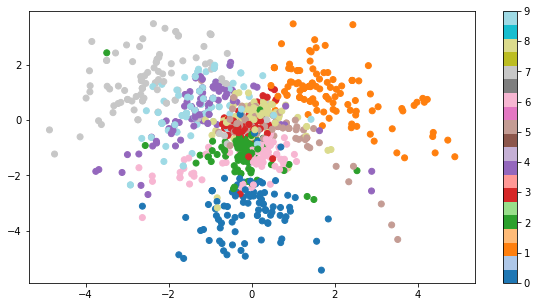

In [23]:
plt.figure(figsize=(10, 5))
plt.scatter(VAE_latents[:, 0], 
            VAE_latents[:, 1], 
            c=y_test0[indices], 
            cmap='tab20')
plt.colorbar()
plt.show()

接著，我們進行 Decoder 的視覺化呈現。

[-4, 4]x[-4, 4](+-0.05，只是比較好看）

In [0]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [0]:
n = 15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n)) #準備好圖片大小給他
for i, yi in enumerate(grid_x_vae): #取第幾次的什麼
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]]) #一筆二維的資料
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size) #每張圖都是digit_size, digit_size
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

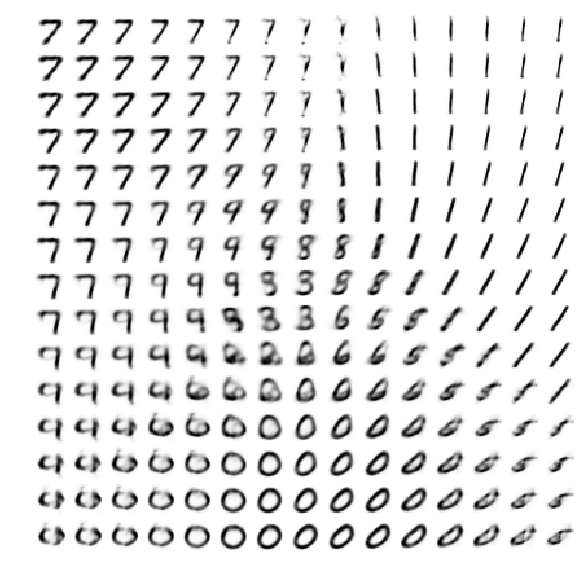

In [26]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

# 4. 動態呈現

In [0]:
def inBetween(start, end, t):
    idx_1 = np.random.choice(np.where(y_train0 == start)[0],1)[0] 
    idx_2 = np.random.choice(np.where(y_train0 == end)[0],1)[0]
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greens')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='YlGn')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greens')

In [86]:
interact(inBetween, 
         t = FloatSlider(value=0.5, min=0, max=1.0,step=0.02,),
         start = (0,9),
         end = (0,9)
        )

interactive(children=(IntSlider(value=4, description='start', max=9), IntSlider(value=4, description='end', ma…

<function __main__.inBetween>